# Backtester Quickstart

Shows how to set up and run a basic options backtest with SPY data.

In [1]:
import math
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from backtester import Backtest, Stock, Type, Direction
from backtester.datahandler import HistoricalOptionsData, TiingoData
from backtester.strategy import Strategy, StrategyLeg
from backtester.statistics import summary, returns_chart, returns_histogram, monthly_returns_heatmap

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load Data

Load SPY stock and options data. If you don't have data yet, run:
```bash
python data/fetch_data.py all --symbols SPY --start 2008-01-01 --end 2025-12-31
```

In [2]:
options_data = HistoricalOptionsData('data/processed/options.csv')
stocks_data = TiingoData('data/processed/stocks.csv')
schema = options_data.schema

print(f'Date range: {stocks_data.start_date} to {stocks_data.end_date}')
print(f'Options rows: {len(options_data):,}')
print(f'Stock rows: {len(stocks_data):,}')

Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00
Options rows: 24,681,663
Stock rows: 4,513


## 2. Define a Strategy

Buy OTM puts on SPY with delta between -0.25 and -0.10, DTE 60-120 days.
Exit when DTE falls below 30.

In [3]:
leg = StrategyLeg('leg_1', schema, option_type=Type.PUT, direction=Direction.BUY)
leg.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= 60) & (schema.dte <= 120) &
    (schema.delta >= -0.25) & (schema.delta <= -0.10)
)
leg.entry_sort = ('delta', False)  # deepest OTM first
leg.exit_filter = (schema.dte <= 30)

strategy = Strategy(schema)
strategy.add_leg(leg)
strategy.add_exit_thresholds(profit_pct=math.inf, loss_pct=math.inf)

## 3. Run the Backtest

Allocate 99.8% to SPY stocks and 0.2% to OTM puts, with monthly rebalancing.

In [4]:
bt = Backtest(
    allocation={'stocks': 0.998, 'options': 0.002, 'cash': 0.0},
    initial_capital=1_000_000
)
bt.stocks = [Stock('SPY', 1.0)]
bt.stocks_data = stocks_data
bt.options_strategy = strategy
bt.options_data = options_data

bt.run(rebalance_freq=1)
print(f'Trades executed: {len(bt.trade_log)}')

/Users/unbalancedparen/projects/options_backtester/backtester/backtester.py:416: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._options_inventory = pd.concat([self._options_inventory, entries_df], ignore_index=True)


Trades executed: 378


## 4. Results

/nix/store/r821y7hq14nnzjb9lhp38a3mrj9b5d19-python3-3.12.12-env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


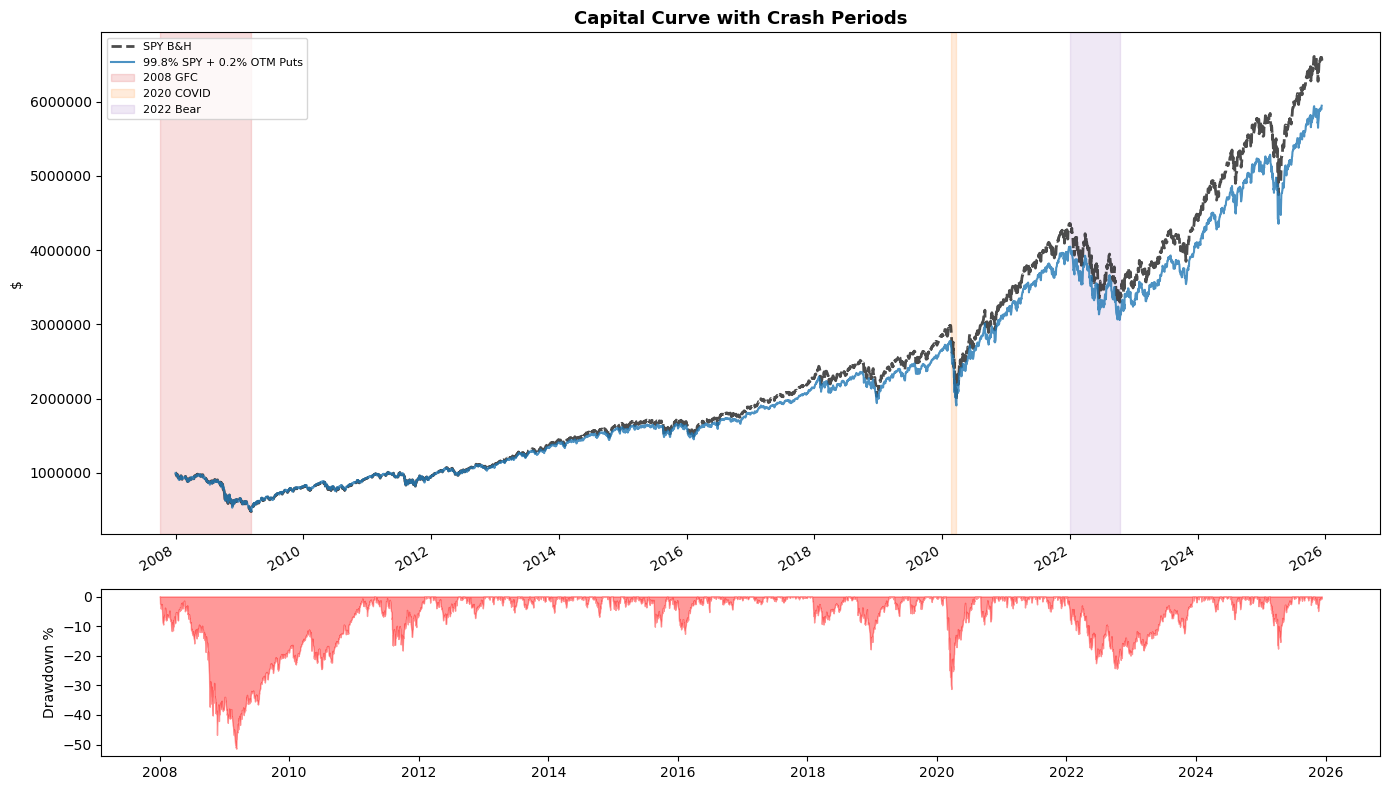

Strategy total return: 494.5%
SPY B&H total return:  555.5%
Excess:                -61.0%


In [5]:
# Capital curve with crash period shading
import matplotlib.patches as mpatches

spy = stocks_data._data[stocks_data._data['symbol'] == 'SPY'].set_index('date')['adjClose'].sort_index()
spy_norm = spy / spy.iloc[0] * 1_000_000

fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price / capital curve
ax = axes[0]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2, label='SPY B&H', alpha=0.7)
bt.balance['total capital'].plot(ax=ax, label='99.8% SPY + 0.2% OTM Puts', alpha=0.8, color='#1f77b4')

# Crash shading
crashes = [('2008 GFC', '2007-10-01', '2009-03-09', '#d62728'),
           ('2020 COVID', '2020-02-19', '2020-03-23', '#ff7f0e'),
           ('2022 Bear', '2022-01-03', '2022-10-12', '#9467bd')]
for label, start, end, color in crashes:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.15, color=color, label=label)

ax.set_title('Capital Curve with Crash Periods', fontsize=13, fontweight='bold')
ax.set_ylabel('$')
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=8, loc='upper left')

# Drawdown
ax = axes[1]
total_cap = bt.balance['total capital']
dd = (total_cap - total_cap.cummax()) / total_cap.cummax() * 100
ax.fill_between(dd.index, dd.values, 0, color='red', alpha=0.4)
ax.set_ylabel('Drawdown %')

plt.tight_layout()
plt.show()

# Key stats
total_ret = (bt.balance['accumulated return'].iloc[-1] - 1) * 100
spy_ret = (spy.iloc[-1] / spy.iloc[0] - 1) * 100
print(f'Strategy total return: {total_ret:.1f}%')
print(f'SPY B&H total return:  {spy_ret:.1f}%')
print(f'Excess:                {total_ret - spy_ret:+.1f}%')

In [6]:
# Summary statistics
if len(bt.trade_log) > 0:
    summary(bt.trade_log, bt.balance)

In [7]:
# Interactive returns chart (Altair)
returns_chart(bt.balance)

alt.VConcatChart(...)

In [8]:
monthly_returns_heatmap(bt.balance)

alt.Chart(...)

In [9]:
returns_histogram(bt.balance)

alt.Chart(...)

## 5. Using the Budget Callable

Instead of a fixed allocation, you can use a callable that returns the options budget dynamically.

**Warning**: Using `stocks: 1.0` with a budget callable creates implicit leverage — the budget adds
capital on top of the 100% stock allocation. For honest results, use the allocation system above.

In [10]:
# Example: budget callable (creates implicit leverage!)
bt2 = Backtest({'stocks': 1.0, 'options': 0.0, 'cash': 0.0}, initial_capital=1_000_000)
bt2.options_budget = lambda date, total_capital: total_capital * 0.001  # 0.1% of capital
bt2.stocks = [Stock('SPY', 1.0)]
bt2.stocks_data = stocks_data
bt2.options_strategy = strategy
bt2.options_data = options_data
bt2.run(rebalance_freq=1)

ret1 = (bt.balance['accumulated return'].iloc[-1] - 1) * 100
ret2 = (bt2.balance['accumulated return'].iloc[-1] - 1) * 100
spy_ret = (spy.iloc[-1] / spy.iloc[0] - 1) * 100

print(f'SPY B&H:                {spy_ret:.1f}%')
print(f'Allocation (no lever):  {ret1:.1f}%')
print(f'Budget callable (lever): {ret2:.1f}%')

/Users/unbalancedparen/projects/options_backtester/backtester/backtester.py:416: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._options_inventory = pd.concat([self._options_inventory, entries_df], ignore_index=True)


SPY B&H:                555.5%
Allocation (no lever):  494.5%
Budget callable (lever): 678.2%
